# <center>__Coffee Bean Image Classification with CNN__</center>

In [1]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

#### Checks for available GPUs and configures TensorFlow to allocate GPU memory gradually if any are found ( only for NVIDIA GPUs )

In [ ]:

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print(e)
        

#### Input data

In [3]:
import numpy as np
import matplotlib.pyplot as plt

train_path = './coffee_bean_data/train/'

test_path = './coffee_bean_data/test/'

batch_size=256

from keras.utils import image_dataset_from_directory

Xtrain = image_dataset_from_directory(train_path, subset='training', validation_split=0.2, batch_size=batch_size, seed=42)

Xval = image_dataset_from_directory(train_path, subset='validation', validation_split=0.2, batch_size=batch_size, seed=42)

classes = Xtrain.class_names

print(classes) 

Found 1200 files belonging to 4 classes.
Using 960 files for training.
Found 1200 files belonging to 4 classes.
Using 240 files for validation.
['Dark', 'Green', 'Light', 'Medium']


In [4]:
Xtest = image_dataset_from_directory(test_path)

Found 400 files belonging to 4 classes.


In [5]:
class_counts = {}
for images, labels in Xtrain:
    for label in labels:
        label = label.numpy()
        class_counts[label] = class_counts.get(label, 0) + 1


for class_name, count in zip(classes, class_counts.values()):
    print(f"{class_name}: {count}")

Dark: 234
Green: 249
Light: 244
Medium: 233


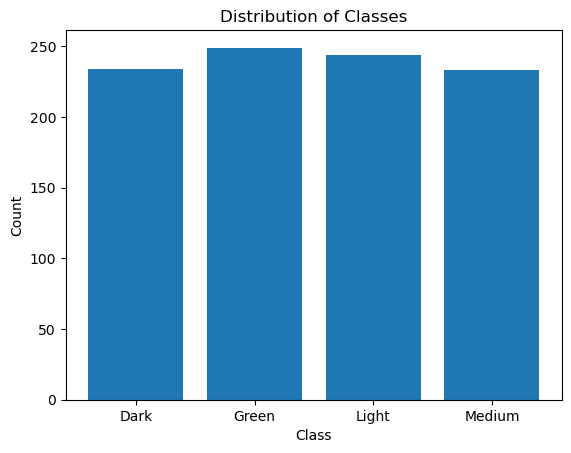

In [6]:
plt.bar(classes, class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()

#### Display of one sample from each class

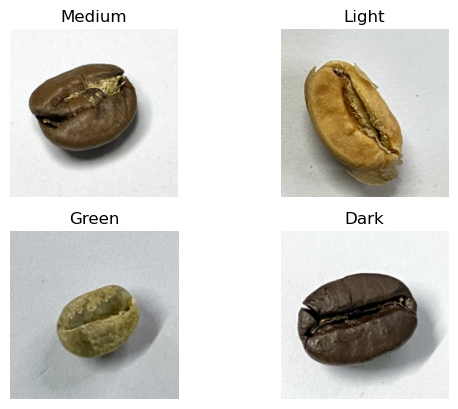

In [7]:
N = 4

plt.figure()
for img, lab in Xtrain.take(1):
    for i in range(N):
        plt.subplot(2, int(N/2), i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes[lab[i]])
        plt.axis('off')

#### Preprocessing the data

In [8]:
from keras import layers
from keras import Sequential

"""
To train the network as effectively as possible, we performed data augmentation. 
By making small modifications (such as rotation and zooming) to existing images, we created new ones and thereby expanded the training set.
"""

data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(256, 256,3)),
    layers.RandomRotation(0.33),
    layers.RandomZoom(0.15)
])


#### Illustration of modifications applied to a single sample

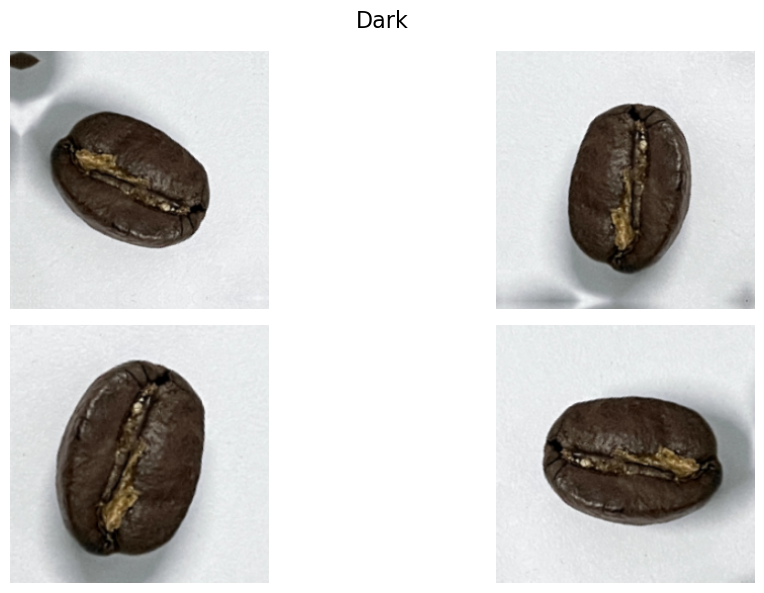

In [9]:
fig, axs = plt.subplots(2, int(N/2), figsize=(12, 6))

for img, lab in Xtrain.take(1):
    fig.suptitle(classes[lab[0].numpy()], fontsize=16)

    for i in range(N):
        aug_img = data_augmentation(img)
        ax = axs[i // (N // 2)][i % (N // 2)]
        ax.imshow(aug_img[0].numpy().astype('uint8'))
        ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
train_images_shape = next(iter(Xtrain.map(lambda x, y: x))).shape
train_labels_shape = next(iter(Xtrain.map(lambda x, y: y))).shape

print("Shape of the first image in the dataset:", train_images_shape)
print("Shape of the first label in the dataset:", train_labels_shape)

Shape of the first image in the dataset: (256, 256, 256, 3)
Shape of the first label in the dataset: (256,)


#### Design and training of the neural network

In [13]:
from tensorflow.keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

data_augmenatition = Sequential([
    layers.RandomFlip("horizontal", input_shape=(256, 256,3)),
    layers.RandomRotation(0.33),
    layers.RandomZoom(0.15)
])

num_classes = len(classes)

def make_model (hp):
    no_units = hp.Int('units', min_value = 3, max_value=15, step=2)
    act = hp.Choice('activation', values=['relu', 'tanh'])
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    opt = Adam(learning_rate=lr)
    dropout = hp.Choice('dropout', values=[0.2,0.02,0.002])
    model = Sequential([
        data_augmenatition,
        layers.Rescaling(1./255, input_shape=(256, 256, 3)),
        layers.Conv2D(32, 3, padding='same', activation=act),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation=act),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation=act),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 3, padding='same', activation=act),
        layers.Dropout(dropout),
        layers.Flatten(),
        layers.Dense(256, activation=act),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.summary()

    model.compile(opt, loss=SparseCategoricalCrossentropy(), metrics='accuracy')
    
    return model

In [14]:
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

stop_early = EarlyStopping(monitor='val_accuracy', patience=5)

tuner = kt.RandomSearch(make_model, objective='val_accuracy', overwrite=True, max_trials=4)

tuner.search(Xtrain , epochs=10, batch_size=32, validation_data=Xval, 
            callbacks=[stop_early], verbose=1)

Trial 4 Complete [00h 09m 47s]
val_accuracy: 0.925000011920929

Best val_accuracy So Far: 0.9583333134651184
Total elapsed time: 00h 34m 19s


In [15]:
best_model = tuner.get_best_models()
best_hyperparam = tuner.get_best_hyperparameters(num_trials=1)[0]


print('Optimal number of neurons in the hidden layer: ', best_hyperparam['units'])
print('Optimal learning rate: ', best_hyperparam['learning_rate'])
print('Optimal activation function: ', best_hyperparam['activation'])
print('Optimal dropout: ', best_hyperparam['dropout'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                    

#### Prevention of overfitting and results

In [16]:
model = tuner.hypermodel.build(best_hyperparam)

stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(Xtrain , epochs=10, batch_size=32, callbacks=[stop_early], verbose=1, validation_data=Xval)

acc = model.evaluate(Xtest, verbose=1)[1]
print('Accuracy on the test set is : ', acc*100, '%.')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                  

#### Graphs of the neural network's performance across training epochs on both the training and validation sets

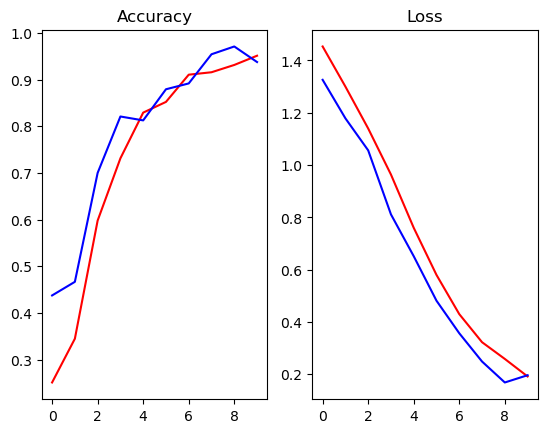

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#The accuracy and loss on the training set are marked in red, while the accuracy and loss on the validation set are marked in blue

plt.figure()
plt.subplot(121)
plt.plot(acc, color='red')
plt.plot(val_acc, color='blue')
plt.title('Accuracy')
plt.subplot(122)
plt.plot(loss, color='red')
plt.plot(val_loss, color='blue')
plt.title('Loss')
plt.show()

#### Confusion matrices for the training and test sets

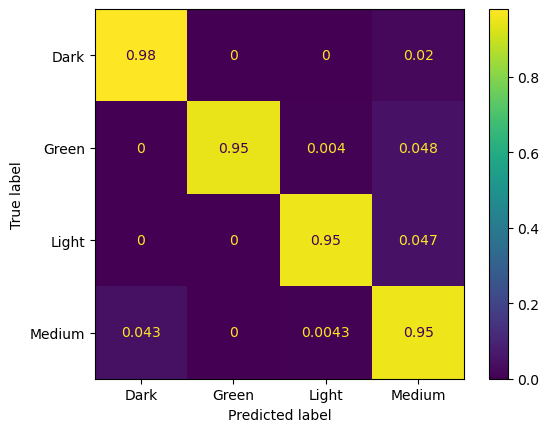

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = np.array([])
pred = np.array([])

for img, lab in Xtrain:
    labels = np.append(labels, lab)
    pred = np.append(pred, np.argmax(model.predict(img, verbose=0), axis=1))


cm = confusion_matrix(labels, pred, normalize='true')
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cmDisplay.plot()
plt.show()

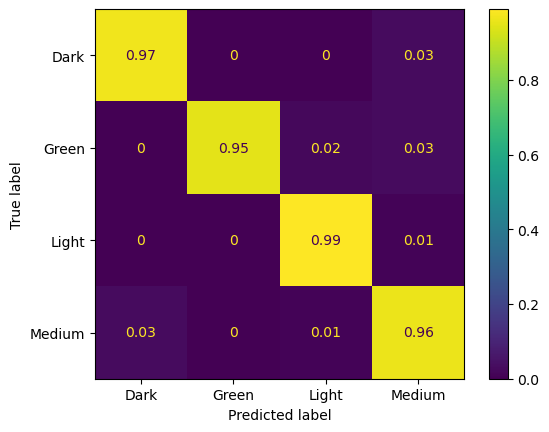

In [19]:
labels = np.array([])
pred = np.array([])

for img, lab in Xtest:
    labels = np.append(labels, lab)
    pred = np.append(pred, np.argmax(model.predict(img, verbose=0), axis=1))
    
cm = confusion_matrix(labels, pred, normalize='true')
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cmDisplay.plot()
plt.show()

#### Examples of both correctly and incorrectly classified instances

1/1 [==============================] - 0s 244ms/step
Number of correctly classified images: 387
Number of incorrectly classified images: 13

Correctly classified images:


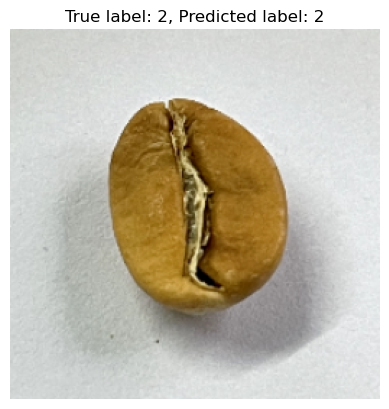

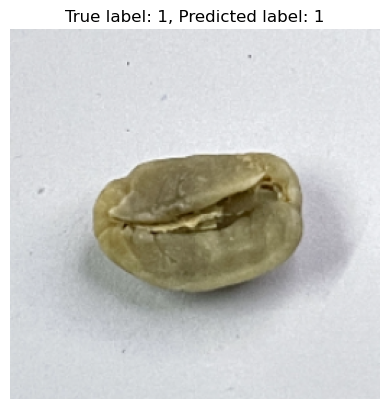

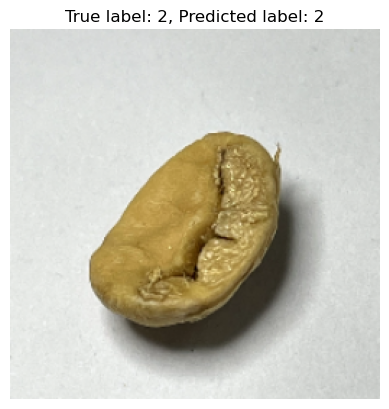

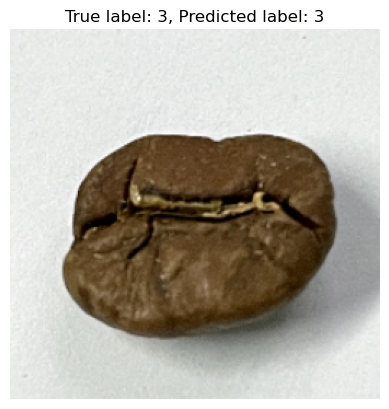

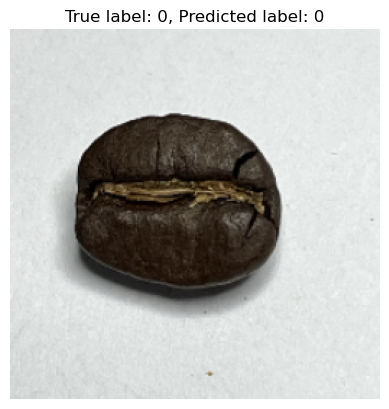

Incorrectly classified images:


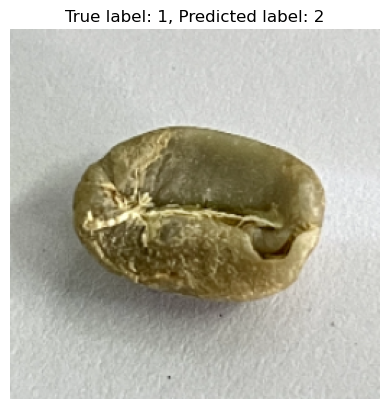

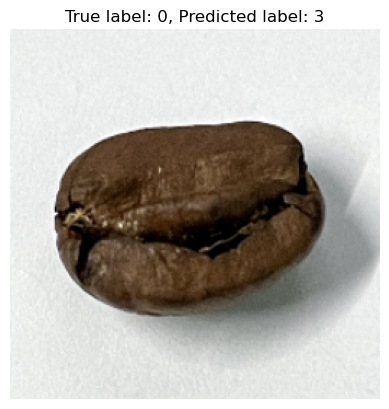

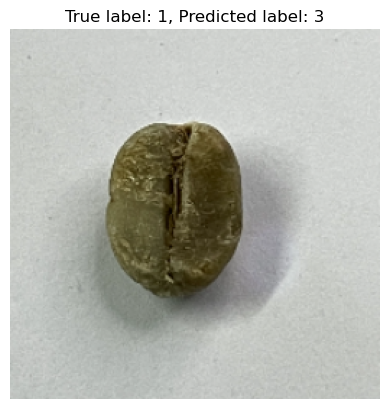

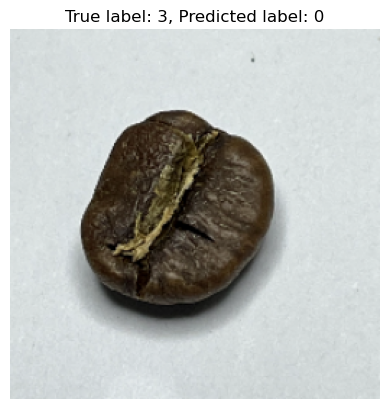

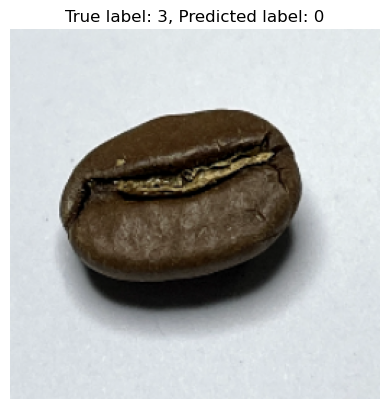

In [20]:
correctly_classified_images = []
misclassified_images = []

# Iterate through the test dataset
for images, labels in Xtest:
    predicted_labels = np.argmax(model.predict(images), axis=1)
    for img, true_label, predicted_label in zip(images, labels, predicted_labels):
        if predicted_label == true_label:
            correctly_classified_images.append((img, true_label, predicted_label))
        else:
            misclassified_images.append((img, true_label, predicted_label))


print("Number of correctly classified images:", len(correctly_classified_images))
print("Number of incorrectly classified images:", len(misclassified_images), end="\n\n")


print("Correctly classified images:")
for img, true_label, predicted_label in correctly_classified_images[:5]: 
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"True label: {true_label}, Predicted label: {predicted_label}")
    plt.axis('off')
    plt.show()

print("Incorrectly classified images:")
for img, true_label, predicted_label in misclassified_images[:5]:  
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"True label: {true_label}, Predicted label: {predicted_label}")
    plt.axis('off')
    plt.show()